In [1]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# Replace 'path/to/teeth_image.jpg' with your actual image path
image_path = 'Teeth Segmentation JSON\\d2\\img\\10.jpg'
annotation_path = 'Teeth Segmentation JSON\\d2\\ann\\10.jpg.json'
mask_path = 'Teeth Segmentation JSON\\d2\\masks_machine\\10.png'

image = cv2.imread(image_path)
# Load the JSON annotations
with open(annotation_path, 'r') as f:
    annotations = json.load(f)


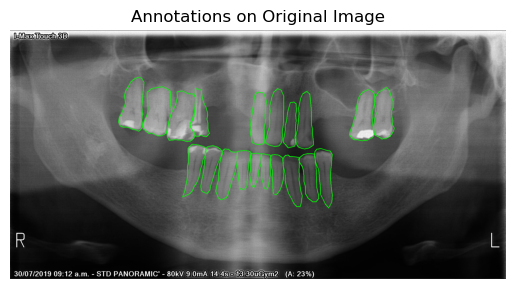

In [3]:
def visualize_annotations(image_path, annotations):
    """
    Visualize the annotations on the original image.

    Args:
        image_path: Path to the image file.
        annotations: A list of annotation dictionaries containing polygon information.
    """

    # Load the original image
    image = cv2.imread(image_path)

    # Draw polygons on the image
    for annotation in annotations['objects']:
        points = np.array(annotation['points']['exterior']).astype(np.int32)
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)

    # Display the image with annotations
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Annotations on Original Image')
    plt.axis('off')
    plt.show()

# Visualize annotations on the original image
visualize_annotations(image_path, annotations)


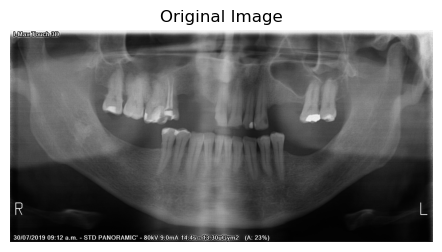

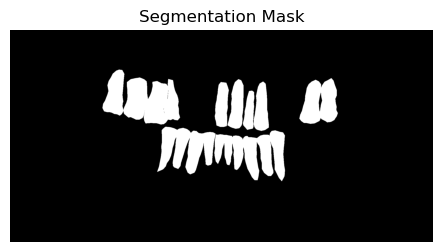

In [10]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

def create_overlay_mask(image, annotations):
    """
    Creates a segmentation mask for an image using polygon overlays based on annotations.

    Args:
        image: The image data as a NumPy array.
        annotations: A list of annotation dictionaries containing polygon information.

    Returns:
        A NumPy array representing the segmentation mask with object class labels.
    """

    # Create a mask with the same dimensions and data type (uint8 for multiple classes)
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)  # Grayscale mask

    # Set background value (assuming BGR format)
    background_color = (0, 0, 0)  # Black color for background

    # Assign a unique value for each object class (you might need to adjust this)
    class_value = 255  # White color for foreground

    # Loop through each annotation polygon
    for annotation in annotations['objects']:
        # Extract polygon points from the annotation
        points = np.array(annotation['points']['exterior'])

        # Use cv2.fillPoly to fill the polygon with the class value
        cv2.fillPoly(mask, [points.astype(np.int32)], class_value)

    return mask

# Create segmentation mask
mask = create_overlay_mask(image, annotations)
# # Display original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# # Display segmentation mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')
plt.show()


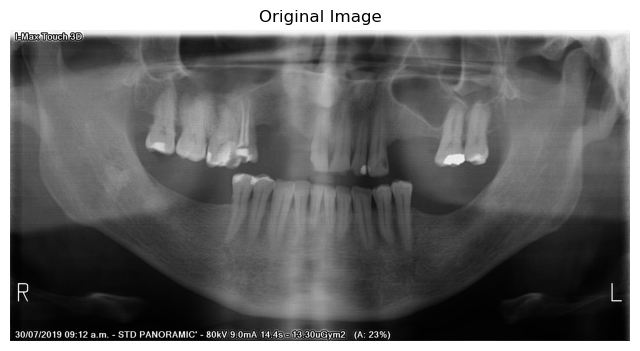

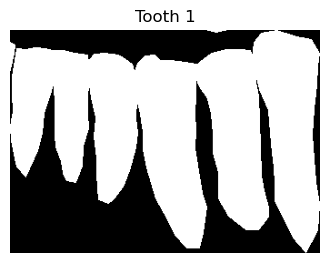

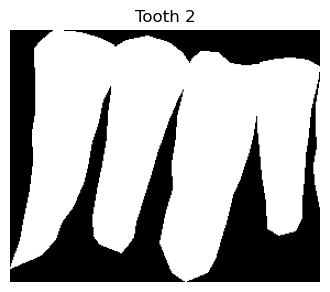

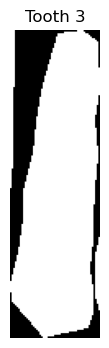

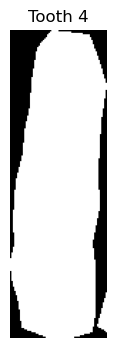

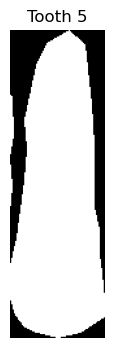

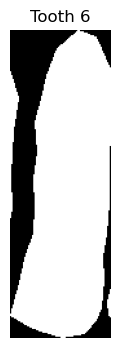

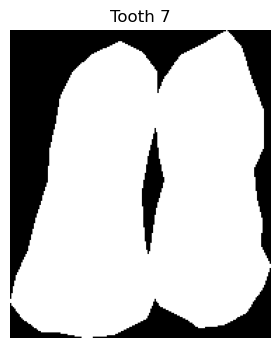

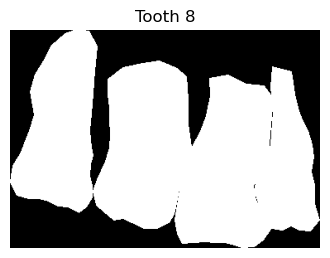

In [6]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

def extract_and_display_sub_images(image_path, mask):
    """
    Extracts sub-images from an image based on segmentation mask and displays them.

    Args:
        image_path: Path to the image file.
        mask: Segmentation mask as a NumPy array.
    """

    # Read the image
    image = cv2.imread(image_path)

    # Display the original image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Find contours in the mask to locate sub-images
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store sub-images
    sub_images = []

    # Loop through contours (sub-images), extract and display them
    for i, contour in enumerate(contours):
        # Get bounding box of contour
        x, y, width, height = cv2.boundingRect(contour)

        # Extract sub-image using bounding box
        sub_image = mask[y:y+height, x:x+width]

        # Append the sub-image to the list
        sub_images.append(sub_image)

        # Display the sub-image
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(sub_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Tooth {i+1}")
        plt.axis('off')
        plt.show()

# Assuming 'mask' is already created using the previous function
mask = create_overlay_mask(image, annotations)

extract_and_display_sub_images(image_path, mask)


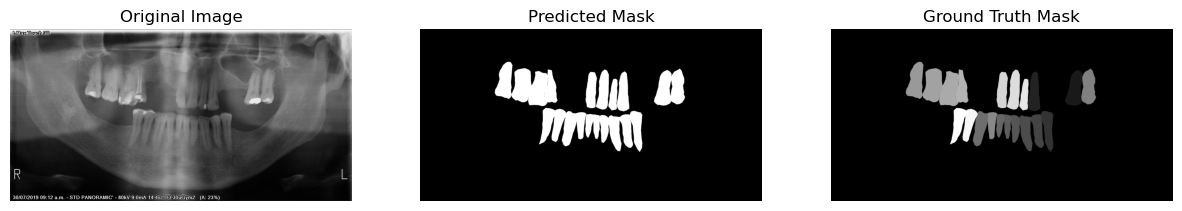

Evaluation Metrics:
IoU: 0.9997300454939725
Dice Coefficient: 1.7688051980085382
Average Boundary Distance: 0.0028453519981075925
pixel_accuracy: 0.9999708131736894


In [7]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

def calculate_iou(mask_gt, mask_pred):
    if mask_gt is None or mask_pred is None:
        return 0.0
    intersection = np.logical_and(mask_gt, mask_pred)
    union = np.logical_or(mask_gt, mask_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_dice_coefficient(mask_gt, mask_pred):
    if mask_gt is None or mask_pred is None:
        return 0.0
    intersection = np.sum(mask_gt * mask_pred)
    dice_coefficient = (2.0 * intersection) / (np.sum(mask_gt) + np.sum(mask_pred))
    return dice_coefficient

def calculate_boundary_distances(mask_gt, mask_pred):
    if mask_gt is None or mask_pred is None:
        return 0.0
    contours_gt, _ = cv2.findContours(mask_gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    distances = []
    for contour_gt in contours_gt:
        min_distance = float('inf')
        for contour_pred in contours_pred:
            distance = cv2.matchShapes(contour_gt, contour_pred, cv2.CONTOURS_MATCH_I2, 0.0)
            min_distance = min(min_distance, distance)
        distances.append(min_distance)
    
    avg_distance = np.mean(distances)
    return avg_distance

def calculate_pixel_accuracy(mask_gt, mask_pred):
    if mask_gt is None or mask_pred is None:
        return 0.0
    
    # Convert masks to boolean arrays for comparison
    mask_gt_bool = mask_gt.astype(bool)
    mask_pred_bool = mask_pred.astype(bool)
    
    # Count the number of correctly classified pixels
    correct_pixels = np.sum(mask_gt_bool == mask_pred_bool)
    
    # Total number of pixels
    total_pixels = mask_gt.shape[0] * mask_gt.shape[1]  # Assuming masks are 2D
    
    # Calculate pixel-wise accuracy
    pixel_accuracy = correct_pixels / total_pixels
    
    return pixel_accuracy

def evaluate_segmentation(image_path, mask_path, annotations_path):
    # Read the original image
    image = cv2.imread(image_path)

    # Read the ground truth mask
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Read annotations (if available)
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    # Extract segmentation mask from annotations
    mask_pred = create_overlay_mask(image, annotations)
    if mask_gt is None:
        print(f"Error: Could not read the mask at {mask_path}")
        return
    if mask_pred is None:
        print("Error: Failed to generate segmentation mask.")
        return
    
    # Calculate IoU
    iou = calculate_iou(mask_gt, mask_pred)

    # Calculate Dice coefficient
    dice_coefficient = calculate_dice_coefficient(mask_gt, mask_pred)

    # # Calculate average boundary distance
    boundary_distance = calculate_boundary_distances(mask_gt, mask_pred)

    pixel_accuracy = calculate_pixel_accuracy(mask_gt, mask_pred)
    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(image[:, :, ::-1])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask_pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(mask_gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.show()

    print("Evaluation Metrics:")
    print(f"IoU: {iou}")
    print(f"Dice Coefficient: {dice_coefficient}")
    print(f"Average Boundary Distance: {boundary_distance}")
    print(f"pixel_accuracy: {pixel_accuracy}")

# Example usage
mask_path = 'Teeth Segmentation JSON\\d2\\masks_machine\\10.png'

evaluate_segmentation(image_path, mask_path, annotation_path)
